# Price Forecast Model

This notebook contains the exploratory data analysis, model training, and evaluation steps for the price forecasting model.

In [326]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style='whitegrid')

In [327]:
# Load the dataset
df = pd.read_csv(r'C:\Users\40108378\OneDrive - Anheuser-Busch InBev\Hedging Commodities\price-forecast-model\data\SAFEX_wheat_friday_df.csv')

# Display the first few rows of the dataset
df.head()

,Date,Price,volume,open_price,Year,USDZAR Curncy,W 1 Comdty,W 2 Comdty,WZ1 Comdty,YW1 Comdty,year_month,max_temp,precipitation,avg_temp,min_temp,active_flag,day
0,2015-05-08,3853,657.0,3820.0,2015,11.9183,476.50,481.50,2681.0,2370.0,201505,72.32070,0.534166,59.4850,46.63575,0,Friday
1,2015-05-15,3810,41.0,3855.0,2015,11.7974,511.00,517.50,2787.0,2403.0,201505,72.32070,0.534166,59.4850,46.63575,0,Friday
2,2015-05-22,3798,154.0,3810.0,2015,11.8919,515.25,523.00,2830.0,2440.0,201505,72.32070,0.534166,59.4850,46.63575,0,Friday
3,2015-05-29,3828,364.0,3825.0,2015,12.1525,477.00,482.25,2730.0,2397.0,201505,72.32070,0.534166,59.4850,46.63575,0,Friday
4,2015-06-05,3853,356.0,3843.0,2015,12.5792,517.00,521.50,2751.0,2437.0,201506,63.05725,2.187500,51.9028,40.72700,0,Friday


In [328]:
volume_df = pd.read_csv(r'C:\Users\40108378\OneDrive - Anheuser-Busch InBev\Hedging Commodities\price-forecast-model\data\safexvolume-uUNihmy6o6q3-20250422T120813Z.csv')

In [329]:
volume_df = volume_df[['DATE', 'PX_VOLUME', 'PX_OPEN']]
volume_df.head()

,DATE,PX_VOLUME,PX_OPEN
0,2024-01-10,3,5960.0
1,2024-02-12,28,5971.0
2,2024-02-13,23,NaN
3,2024-02-14,20,NaN
4,2024-02-16,17,NaN


In [330]:
# Filter the DataFrames for the year 2024
volume_df['DATE'] = pd.to_datetime(volume_df['DATE'])
df['Date'] = pd.to_datetime(df['Date'])

volume_df_2024 = volume_df[volume_df['DATE'].dt.year == 2024]
df_2024 = df[df['Date'].dt.year == 2024]

# Merge the two DataFrames on the date columns
df_2024 = df_2024.merge(volume_df_2024[['DATE', 'PX_VOLUME', 'PX_OPEN']], left_on='Date', right_on='DATE', how='left')

# Replace the 'volume' and 'open_price' columns in df_2024 with the corresponding columns from volume_df_2024
df_2024['volume'] = df_2024['PX_VOLUME']
df_2024['open_price'] = df_2024['PX_OPEN']

# Drop the extra 'DATE', 'PX_VOLUME', and 'PX_OPEN' columns
df_2024.drop(columns=['DATE', 'PX_VOLUME', 'PX_OPEN'], inplace=True)

# Display the updated DataFrame
print(df_2024.head())

        Date  Price  volume  open_price  Year  USDZAR Curncy  W 1 Comdty  \
0 2024-05-03   6193   226.0      6260.0  2024        18.5102      606.00   
1 2024-05-10   6319    60.0      6200.0  2024        18.4460      645.75   
2 2024-05-17   6384   117.0      6350.0  2024        18.1665      651.25   
3 2024-05-24   6483   539.0      6495.0  2024        18.4174      697.25   
4 2024-05-31   6640   800.0      6600.0  2024        18.7930      678.50   

   W 2 Comdty  WZ1 Comdty  YW1 Comdty  year_month  max_temp  precipitation  \
0       622.5      5045.0      4155.0      202405   74.3484         0.3125   
1       663.5      4936.0      4031.0      202405   74.3484         0.3125   
2       672.0      4857.0      3935.0      202405   74.3484         0.3125   
3       717.5      5046.0      4061.0      202405   74.3484         0.3125   
4       699.5      5302.0      4138.0      202405   74.3484         0.3125   

   avg_temp  min_temp  active_flag     day  
0  60.91235  47.46425        

In [331]:
# Filter out rows where the year in the 'Date' column is 2024
df = df[df['Date'].dt.year != 2024]

# Display the updated DataFrame
print(df.head())

        Date  Price  volume  open_price  Year  USDZAR Curncy  W 1 Comdty  \
0 2015-05-08   3853   657.0      3820.0  2015        11.9183      476.50   
1 2015-05-15   3810    41.0      3855.0  2015        11.7974      511.00   
2 2015-05-22   3798   154.0      3810.0  2015        11.8919      515.25   
3 2015-05-29   3828   364.0      3825.0  2015        12.1525      477.00   
4 2015-06-05   3853   356.0      3843.0  2015        12.5792      517.00   

   W 2 Comdty  WZ1 Comdty  YW1 Comdty  year_month  max_temp  precipitation  \
0      481.50      2681.0      2370.0      201505  72.32070       0.534166   
1      517.50      2787.0      2403.0      201505  72.32070       0.534166   
2      523.00      2830.0      2440.0      201505  72.32070       0.534166   
3      482.25      2730.0      2397.0      201505  72.32070       0.534166   
4      521.50      2751.0      2437.0      201506  63.05725       2.187500   

   avg_temp  min_temp  active_flag     day  
0   59.4850  46.63575        

In [332]:
# Concatenate df and df_2024
df = pd.concat([df, df_2024], ignore_index=True)

# Display the combined DataFrame
print(df.head())
print(df.tail())

        Date  Price  volume  open_price  Year  USDZAR Curncy  W 1 Comdty  \
0 2015-05-08   3853   657.0      3820.0  2015        11.9183      476.50   
1 2015-05-15   3810    41.0      3855.0  2015        11.7974      511.00   
2 2015-05-22   3798   154.0      3810.0  2015        11.8919      515.25   
3 2015-05-29   3828   364.0      3825.0  2015        12.1525      477.00   
4 2015-06-05   3853   356.0      3843.0  2015        12.5792      517.00   

   W 2 Comdty  WZ1 Comdty  YW1 Comdty  year_month  max_temp  precipitation  \
0      481.50      2681.0      2370.0      201505  72.32070       0.534166   
1      517.50      2787.0      2403.0      201505  72.32070       0.534166   
2      523.00      2830.0      2440.0      201505  72.32070       0.534166   
3      482.25      2730.0      2397.0      201505  72.32070       0.534166   
4      521.50      2751.0      2437.0      201506  63.05725       2.187500   

   avg_temp  min_temp  active_flag     day  
0   59.4850  46.63575        

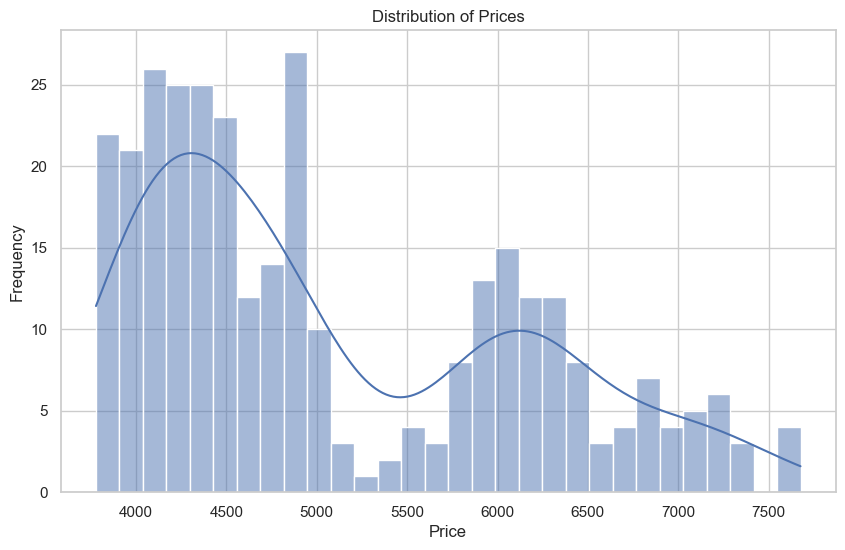

In [333]:
# Exploratory Data Analysis
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

# Visualize the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], bins=30, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [334]:
# Ensure the 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create covid_flag for data in 2020
df['covid_flag'] = df['Date'].dt.year.apply(lambda x: 1 if x == 2020 else 0)

# Create war_flag for data in 2022
df['war_flag'] = df['Date'].dt.year.apply(lambda x: 1 if x == 2022 else 0)

# Display the updated dataframe
df[['Date', 'covid_flag', 'war_flag']].head()
# Add a seasonality column based on the month
df['seasonality'] = df['Date'].dt.month % 12 // 3 + 1


# Display the updated dataframe with the new column
df[['Date', 'seasonality']].head()



,Date,seasonality
0,2015-05-08,2
1,2015-05-15,2
2,2015-05-22,2
3,2015-05-29,2
4,2015-06-05,3


In [335]:
# Add a price_diff column
df['price_diff'] = df['Price'].diff()

# Display the updated DataFrame
df.head()

,Date,Price,volume,open_price,Year,USDZAR Curncy,W 1 Comdty,W 2 Comdty,WZ1 Comdty,YW1 Comdty,...,max_temp,precipitation,avg_temp,min_temp,active_flag,day,covid_flag,war_flag,seasonality,price_diff
0,2015-05-08,3853,657.0,3820.0,2015,11.9183,476.50,481.50,2681.0,2370.0,...,72.32070,0.534166,59.4850,46.63575,0,Friday,0,0,2,NaN
1,2015-05-15,3810,41.0,3855.0,2015,11.7974,511.00,517.50,2787.0,2403.0,...,72.32070,0.534166,59.4850,46.63575,0,Friday,0,0,2,-43.0
2,2015-05-22,3798,154.0,3810.0,2015,11.8919,515.25,523.00,2830.0,2440.0,...,72.32070,0.534166,59.4850,46.63575,0,Friday,0,0,2,-12.0
3,2015-05-29,3828,364.0,3825.0,2015,12.1525,477.00,482.25,2730.0,2397.0,...,72.32070,0.534166,59.4850,46.63575,0,Friday,0,0,2,30.0
4,2015-06-05,3853,356.0,3843.0,2015,12.5792,517.00,521.50,2751.0,2437.0,...,63.05725,2.187500,51.9028,40.72700,0,Friday,0,0,3,25.0


In [336]:
from lightgbm import LGBMRegressor

In [337]:
df.tail(60)

,Date,Price,volume,open_price,Year,USDZAR Curncy,W 1 Comdty,W 2 Comdty,WZ1 Comdty,YW1 Comdty,...,max_temp,precipitation,avg_temp,min_temp,active_flag,day,covid_flag,war_flag,seasonality,price_diff
262,2023-06-09,6296,284.0,6295.0,2023,18.7564,630.25,641.75,3618.0,3691.0,...,63.67835,2.153334,52.59055,41.49335,0,Friday,0,0,3,-50.0
263,2023-06-23,6504,1305.0,6500.0,2023,18.7542,733.25,746.50,3896.0,3999.0,...,63.67835,2.153334,52.59055,41.49335,0,Friday,0,0,3,208.0
264,2023-06-30,6365,207.0,6346.0,2023,18.8485,636.25,651.00,3637.0,3719.0,...,63.67835,2.153334,52.59055,41.49335,0,Friday,0,0,3,-139.0
265,2023-07-07,6262,325.0,6257.0,2023,18.8670,639.50,649.50,3545.0,3603.0,...,63.31315,1.320000,51.26825,39.20295,0,Friday,0,0,3,-103.0
266,2023-07-14,6054,292.0,6050.0,2023,18.1077,NaN,661.50,3537.0,3591.0,...,63.31315,1.320000,51.26825,39.20295,0,Friday,0,0,3,-208.0
267,2023-07-21,6401,583.0,6399.0,2023,17.9600,697.50,717.75,3773.0,3791.0,...,63.31315,1.320000,51.26825,39.20295,0,Friday,0,0,3,347.0
268,2023-07-28,6341,708.0,6357.0,2023,17.6312,704.25,728.00,3635.0,3658.0,...,63.31315,1.320000,51.26825,39.20295,0,Friday,0,0,3,-60.0
269,2023-08-04,6385,630.0,6350.0,2023,18.4575,633.00,660.25,3727.0,3747.0,...,68.69005,0.544166,55.15515,41.60060,0,Friday,0,0,3,44.0
270,2023-08-11,6450,513.0,6439.0,2023,18.9508,626.75,653.75,3650.0,3673.0,...,68.69005,0.544166,55.15515,41.60060,0,Friday,0,0,3,65.0
271,2023-08-18,6448,760.0,6431.0,2023,18.9974,613.25,639.00,3642.0,3687.0,...,68.69005,0.544166,55.15515,41.60060,0,Friday,0,0,3,-2.0


In [338]:
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA

# Initialize the starting point for the loop
current_date = pd.Timestamp('2023-05-05')
horizon = 31  # Number of weeks to extrapolate

# Loop until the end of December 2023
while current_date <= pd.Timestamp('2023-12-31'):
    data_2022_2023 = df[df['Date'] < current_date]
    for i in range (0, horizon):
        # Use 20-day moving averages for extrapolation
        forecasted_values = {}
        for column in ['price_diff', 'volume', 'open_price', 'USDZAR Curncy', 'W 1 Comdty', 'W 2 Comdty', 
                   'WZ1 Comdty', 'YW1 Comdty', 'max_temp', 'precipitation', 'avg_temp', 'min_temp']:
                if len(data_2022_2023[column]) >= 25:
                    forecasted_values[column] = data_2022_2023[column].rolling(window=120).mean().iloc[-1]
                else:
                    forecasted_values[column] = data_2022_2023[column].mean()
                

        # Create a new row with extrapolated data
        new_row = {
            'Date': current_date + timedelta(weeks=i),
            'volume': forecasted_values['volume'],
            'open_price': forecasted_values['open_price'],
            'USDZAR Curncy': forecasted_values['USDZAR Curncy'],
            'W 1 Comdty': forecasted_values['W 1 Comdty'],
            'W 2 Comdty': forecasted_values['W 2 Comdty'],
            'WZ1 Comdty': forecasted_values['WZ1 Comdty'],
            'YW1 Comdty': forecasted_values['YW1 Comdty'],
            'price_diff': forecasted_values['price_diff'],
            'year_month': (current_date + timedelta(weeks=i)).year * 100 + (current_date + timedelta(weeks=i)).month,
            'max_temp': forecasted_values['max_temp'],
            'precipitation': forecasted_values['precipitation'],
            'avg_temp': forecasted_values['avg_temp'],
            'min_temp': forecasted_values['min_temp'],
            'active_flag': 0,
            'covid_flag': 0,
            'war_flag': 0,
            'day': 'Friday',
            'seasonality': (current_date + timedelta(weeks=i)).month % 12 // 3 + 1
        }
        # Append the new row to the dataframe
        data_2022_2023 = pd.concat([data_2022_2023, pd.DataFrame([new_row])], ignore_index=True)
    print(f"Extrapolated data until {current_date + timedelta(weeks=horizon)}")
    print(data_2022_2023.tail(32))
    # Prepare the data for training
    features = ['volume', 'open_price', 'USDZAR Curncy', 'W 1 Comdty', 'W 2 Comdty', 
                'WZ1 Comdty', 'YW1 Comdty', 'price_diff', 'max_temp', 'precipitation', 
                'avg_temp', 'min_temp']
    target = 'Price'
    X_train = df[df['Date'] <= current_date][features].astype(float)
    y_train = df[df['Date'] <= current_date][target].astype(float)
    X_test = data_2022_2023[data_2022_2023['Date'] > current_date][features].astype(float)
    y_test = df[(df['Date'] > current_date) & (df['Date'] <= pd.Timestamp('2023-12-31'))][target].astype(float)

    # Ensure X_test and y_test have the same length
    min_length = min(len(X_test), len(y_test))
    X_test = X_test.iloc[:min_length]
    y_test = y_test.iloc[:min_length]

    # Train the XGB model
    lgbm_model = LGBMRegressor(random_state=42, max_depth=5, n_estimators=100, learning_rate=0.2)
    # Drop NaN values from training data
    print(X_train.isnull().sum())
    print(y_train.isnull().sum())
    # Train the LGBM model
    lgbm_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = lgbm_model.predict(X_test)
    print(len(y_pred))
    print(len(y_test))  
    horizon_array = np.arange(1, horizon + 1)
    # Ensure the lengths of y_pred and horizon_array match
    if len(y_pred) != len(horizon_array):
        horizon_array = horizon_array[:len(y_pred)]

    # Create a DataFrame for predictions
    prediction_current_date = pd.DataFrame({
        'Date': X_test.index,
        'Predicted_Price': y_pred,
        'Horizon': horizon_array
    })
    prediction_current_date = pd.DataFrame({'Date': X_test.index, 'Predicted_Price': y_pred, 'Horizon':horizon_array })
    current_date_str = current_date.strftime('%Y-%m-%d')
    prediction_current_date.to_csv(f'predictions_{current_date_str}.csv', index=False)
    
    mse = mean_squared_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Percentage Error: {mape*100:.2f}%")
    current_date += timedelta(weeks=1)
    horizon -= 1
    

Extrapolated data until 2023-12-08 00:00:00
          Date   Price       volume   open_price    Year  USDZAR Curncy  \
256 2022-12-09  6682.0  1154.000000  6685.000000  2022.0      17.354200   
257 2023-05-05     NaN   930.250000  5517.966667     NaN      15.832991   
258 2023-05-12     NaN   936.752083  5527.816389     NaN      15.845477   
259 2023-05-19     NaN   942.341684  5537.339859     NaN      15.860132   
260 2023-05-26     NaN   948.569531  5546.734358     NaN      15.874162   
261 2023-06-02     NaN   954.499277  5555.873811     NaN      15.890114   
262 2023-06-09     NaN   961.645105  5565.256092     NaN      15.906400   
263 2023-06-16     NaN   967.408814  5574.591560     NaN      15.919822   
264 2023-06-23     NaN   970.003887  5583.904823     NaN      15.929274   
265 2023-06-30     NaN   971.753920  5591.834030     NaN      15.934470   
266 2023-07-07     NaN   971.926869  5599.557647     NaN      15.940177   
267 2023-07-14     NaN   976.276260  5607.290627     NaN

ValueError: Input data must be 2 dimensional and non empty.

In [339]:
import os
# Define the directory where the prediction CSV files are stored
predictions_dir = r'./'  # Replace with the actual directory path if different

# List all CSV files in the directory
csv_files = [file for file in os.listdir(predictions_dir) if file.startswith('predictions_') and file.endswith('.csv')]

# Initialize an empty list to store DataFrames
predictions_list = []
# Extract the date from the file name and add it as a new column
for file in csv_files:
    file_date = file.split('_')[1].split('.')[0]  # Extract the date part from the file name
    df_new = pd.read_csv(os.path.join(predictions_dir, file))
    df_new['File_Date'] = file_date  # Add the extracted date as a new column
    predictions_list.append(df_new)

# Concatenate all DataFrames into a single DataFrame
all_predictions = pd.concat(predictions_list, ignore_index=True)

# Display the combined DataFrame
print(all_predictions.head())
print(f"Total predictions loaded: {len(all_predictions)}")


   Date  Predicted_Price  Horizon   File_Date
0   258      5356.677792        1  2023-05-05
1   259      5356.677792        2  2023-05-05
2   260      5356.677792        3  2023-05-05
3   261      5356.677792        4  2023-05-05
4   262      5356.677792        5  2023-05-05
Total predictions loaded: 465


In [340]:
# Convert 'File_Date' to datetime format
all_predictions['File_Date'] = pd.to_datetime(all_predictions['File_Date'])

# Calculate the prediction date by adding the horizon in weeks
all_predictions['prediction_date'] = all_predictions['File_Date'] + pd.to_timedelta(all_predictions['Horizon'], unit='W')

# Display the updated DataFrame
print(all_predictions.head())

   Date  Predicted_Price  Horizon  File_Date prediction_date
0   258      5356.677792        1 2023-05-05      2023-05-12
1   259      5356.677792        2 2023-05-05      2023-05-19
2   260      5356.677792        3 2023-05-05      2023-05-26
3   261      5356.677792        4 2023-05-05      2023-06-02
4   262      5356.677792        5 2023-05-05      2023-06-09


In [341]:
all_predictions.drop(columns=['Date'], inplace=True)
all_predictions.rename(columns={'prediction_date': 'Date'}, inplace=True)

In [342]:
# Ensure the 'Date' column in both DataFrames is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
all_predictions['Date'] = pd.to_datetime(all_predictions['Date'], errors='coerce')

# Convert the 'Date' columns to string format for matching
df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
all_predictions['Date'] = all_predictions['Date'].dt.strftime('%Y-%m-%d')

# Merge the DataFrames on the 'Date' column
merged_predictions = all_predictions.merge(df[['Date', 'Price']], on='Date', how='left')

# Display the merged DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date   Price
0      5356.677792        1 2023-05-05  2023-05-12  6546.0
1      5356.677792        2 2023-05-05  2023-05-19  6530.0
2      5356.677792        3 2023-05-05  2023-05-26  6356.0
3      5356.677792        4 2023-05-05  2023-06-02  6346.0
4      5356.677792        5 2023-05-05  2023-06-09  6296.0


In [343]:
# Map the 'File_Date' to the corresponding 'Price' from the 'df' DataFrame
merged_predictions['Trained_Price'] = merged_predictions['File_Date'].dt.strftime('%Y-%m-%d').map(
    df.set_index('Date')['Price']
)

# Display the updated DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date   Price  Trained_Price
0      5356.677792        1 2023-05-05  2023-05-12  6546.0         6383.0
1      5356.677792        2 2023-05-05  2023-05-19  6530.0         6383.0
2      5356.677792        3 2023-05-05  2023-05-26  6356.0         6383.0
3      5356.677792        4 2023-05-05  2023-06-02  6346.0         6383.0
4      5356.677792        5 2023-05-05  2023-06-09  6296.0         6383.0


In [344]:
# Calculate MAPE
merged_predictions['mape'] = abs(merged_predictions['Predicted_Price'] - merged_predictions['Price']) / merged_predictions['Price']

# Calculate Directional Accuracy
merged_predictions['dir_acc'] = merged_predictions.apply(
    lambda row: 1 if (
        (row['Price'] > row['Trained_Price'] and row['Predicted_Price'] > row['Trained_Price']) or
        (row['Price'] < row['Trained_Price'] and row['Predicted_Price'] < row['Trained_Price']) or
        (row['Price'] == row['Trained_Price'])
    ) else 0, axis=1
)

# Display the updated DataFrame
print(merged_predictions.head())

   Predicted_Price  Horizon  File_Date        Date   Price  Trained_Price  \
0      5356.677792        1 2023-05-05  2023-05-12  6546.0         6383.0   
1      5356.677792        2 2023-05-05  2023-05-19  6530.0         6383.0   
2      5356.677792        3 2023-05-05  2023-05-26  6356.0         6383.0   
3      5356.677792        4 2023-05-05  2023-06-02  6346.0         6383.0   
4      5356.677792        5 2023-05-05  2023-06-09  6296.0         6383.0   

       mape  dir_acc  
0  0.181687        0  
1  0.179682        0  
2  0.157225        1  
3  0.155897        1  
4  0.149193        1  


In [345]:
merged_predictions=merged_predictions.dropna(axis=0, how='any')

In [346]:
merged_predictions

,Predicted_Price,Horizon,File_Date,Date,Price,Trained_Price,mape,dir_acc
0,5356.677792,1,2023-05-05,2023-05-12,6546.0,6383.0,0.181687,0
1,5356.677792,2,2023-05-05,2023-05-19,6530.0,6383.0,0.179682,0
2,5356.677792,3,2023-05-05,2023-05-26,6356.0,6383.0,0.157225,1
3,5356.677792,4,2023-05-05,2023-06-02,6346.0,6383.0,0.155897,1
4,5356.677792,5,2023-05-05,2023-06-09,6296.0,6383.0,0.149193,1
...,...,...,...,...,...,...,...,...
460,6012.554883,2,2023-11-10,2023-11-24,5866.0,5942.0,0.024984,0
461,6012.554883,3,2023-11-10,2023-12-01,5798.0,5942.0,0.037005,0
462,5938.326773,1,2023-11-17,2023-11-24,5866.0,5900.0,0.012330,0
463,5938.326773,2,2023-11-17,2023-12-01,5798.0,5900.0,0.024203,0


In [347]:
# Convert 'Date' column to datetime format if not already
merged_predictions['Date'] = pd.to_datetime(merged_predictions['Date'])

# Filter rows where the year in 'Date' is 2023
merged_predictions_2023 = merged_predictions[merged_predictions['Date'].dt.year == 2023]

# Display the filtered DataFrame
print(merged_predictions_2023)

     Predicted_Price  Horizon  File_Date       Date   Price  Trained_Price  \
0        5356.677792        1 2023-05-05 2023-05-12  6546.0         6383.0   
1        5356.677792        2 2023-05-05 2023-05-19  6530.0         6383.0   
2        5356.677792        3 2023-05-05 2023-05-26  6356.0         6383.0   
3        5356.677792        4 2023-05-05 2023-06-02  6346.0         6383.0   
4        5356.677792        5 2023-05-05 2023-06-09  6296.0         6383.0   
..               ...      ...        ...        ...     ...            ...   
460      6012.554883        2 2023-11-10 2023-11-24  5866.0         5942.0   
461      6012.554883        3 2023-11-10 2023-12-01  5798.0         5942.0   
462      5938.326773        1 2023-11-17 2023-11-24  5866.0         5900.0   
463      5938.326773        2 2023-11-17 2023-12-01  5798.0         5900.0   
464      6056.079272        1 2023-11-24 2023-12-01  5798.0         5866.0   

         mape  dir_acc  
0    0.181687        0  
1    0.179682

In [348]:
# Group by 'Horizon' and calculate the sum and count of 'dir_acc' values
horizon_dir_acc_stats = merged_predictions_2023.groupby('Horizon')['dir_acc'].agg(['sum', 'count'])

# Calculate the percentage
horizon_dir_acc_stats['percentage'] = (horizon_dir_acc_stats['sum'] / horizon_dir_acc_stats['count']) * 100

# Average MAPE
horizon_dir_acc_stats['avg_mape'] = merged_predictions_2023.groupby('Horizon')['mape'].mean()

# Display the result
print(horizon_dir_acc_stats)

         sum  count  percentage  avg_mape
Horizon                                  
1         16     28   57.142857  0.084882
2         17     27   62.962963  0.083555
3         14     26   53.846154  0.081973
4         17     25   68.000000  0.081656
5         19     24   79.166667  0.075691
6         19     23   82.608696  0.073782
7         16     23   69.565217  0.075710
8         19     22   86.363636  0.072519
9         18     21   85.714286  0.070259
10        15     20   75.000000  0.071167
11        15     19   78.947368  0.070677
12        16     18   88.888889  0.067156
13        15     17   88.235294  0.063812
14        14     16   87.500000  0.060850
15        13     15   86.666667  0.057594
16        14     14  100.000000  0.052838
17        13     13  100.000000  0.052380
18        12     12  100.000000  0.049236
19        11     11  100.000000  0.046542
20        10     10  100.000000  0.047525
21         9      9  100.000000  0.042777
22         8      8  100.000000  0

In [359]:
# Group by 'Horizon' and take the first value for each group
first_values_per_horizon = merged_predictions.groupby('Horizon').first().reset_index()

# Display the resulting DataFrame
print(first_values_per_horizon)


    Horizon  Predicted_Price  File_Date       Date   Price  Trained_Price  \
0         1      5356.677792 2023-05-05 2023-05-12  6546.0         6383.0   
1         2      5356.677792 2023-05-05 2023-05-19  6530.0         6383.0   
2         3      5356.677792 2023-05-05 2023-05-26  6356.0         6383.0   
3         4      5356.677792 2023-05-05 2023-06-02  6346.0         6383.0   
4         5      5356.677792 2023-05-05 2023-06-09  6296.0         6383.0   
5         6      5422.323766 2023-05-12 2023-06-23  6504.0         6546.0   
6         7      5356.677792 2023-05-05 2023-06-23  6504.0         6383.0   
7         8      5356.677792 2023-05-05 2023-06-30  6365.0         6383.0   
8         9      5356.677792 2023-05-05 2023-07-07  6262.0         6383.0   
9        10      5358.828402 2023-05-05 2023-07-14  6054.0         6383.0   
10       11      5358.828402 2023-05-05 2023-07-21  6401.0         6383.0   
11       12      5599.453899 2023-05-05 2023-07-28  6341.0         6383.0   

In [349]:
sum_dir_acc = merged_predictions_2023['dir_acc'].sum()
print(sum_dir_acc)

354


In [350]:
horizon_dir_acc_stats.to_csv('output/horizon_dir_acc_stats_2023.csv', index=True)

In [352]:
%pip install shap

  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
   ---------------------------------------- 0.0/544.4 kB ? eta -:--:--
   ---------------------------------------- 544.4/544.4 kB 3.6 MB/s eta 0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 16.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/30.3 MB ? eta -:--:--
   ------- -------------------------------- 5.8/30.3 MB 29.4 MB/s eta 0:00:01
   ------------ --------------------------- 9.2/30.3 MB 21.1 MB/s eta 0:00:02
   ----------------- ---------------------- 13.1/30.3 MB 20.6 MB/s eta 0:00:01
   ---------------------- ----------------- 17.0/30.3 MB 19.9 MB/s eta 0:00:01
   --------------------------- ------------ 21.0/30.3 MB 19.5 MB/s eta 0:00:01
   --------------------------------- ------ 25.2/30.3 MB 19.7 MB/s eta 0:00:01
   ---------------------------------------  29.

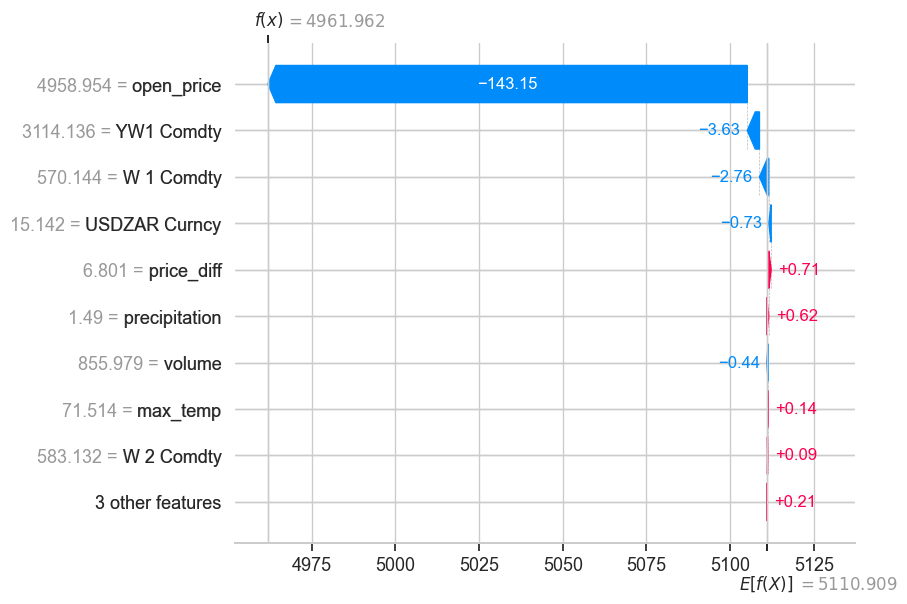

In [356]:
# Calculate the mean of SHAP values across all instances
mean_shap_values = shap_values.values.mean(axis=0)

# Create a SHAP explanation object for the mean values
mean_shap_explanation = shap.Explanation(
    values=mean_shap_values,
    base_values=shap_values.base_values.mean(),
    data=X_train.mean(axis=0).values,
    feature_names=X_train.columns  # Ensure feature names are included
)

# Generate the waterfall plot for the mean SHAP values with labels
shap.plots.waterfall(mean_shap_explanation, show=True)
